# Imports/google drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install keras_unet_collection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 6.8 MB/s 


In [ ]:
# from keras.utils.np_utils import normalize
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
from datetime import datetime 
from PIL import Image
import random
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# Custom metrics

In [ ]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# Get images

## Download augmented dataset from drobox


In [ ]:

!wget -O augmented_dataset.zip https://www.dropbox.com/s/ib1llisrgxmp2ve/OG800.zip?dl=0
!unzip /content/augmented_dataset.zip

--2022-06-12 21:52:52--  https://www.dropbox.com/s/ib1llisrgxmp2ve/OG800.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ib1llisrgxmp2ve/OG800.zip [following]
--2022-06-12 21:52:52--  https://www.dropbox.com/s/raw/ib1llisrgxmp2ve/OG800.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1c6a46aa27053b4ebc661e1be9.dl.dropboxusercontent.com/cd/0/inline/BnGtIeHod8bUY0A4w7f3GZaEzelZNkGCNaZK8XfuftSlQQVmAizrhBfveOA-sugGAhy4w-WZiGbm_SpJzYdMd5gGra1tWA5Fn_rJha0OccEmAmqw-LirTmxk1m69Xfyac4t2IuVov8Q06t42Mi3SAlgQfRUH_ehNw0GVpOdv1PVUNg/file# [following]
--2022-06-12 21:52:53--  https://uc1c6a46aa27053b4ebc661e1be9.dl.dropboxusercontent.com/cd/0/inline/BnGtIeHod8bUY0A4w7f3GZaEzelZNkGCNaZK8XfuftSlQQVmAizrhBfveOA-sugGAhy4w-WZ

## Process augmented dataset

In [ ]:
augmented_images_dir_path = "/content/augmented_images"
augmented_masks_dir_path =  "/content/augmented_masks"

In [ ]:
image_names = glob.glob(f"{augmented_images_dir_path}/*.jpg")
image_names.sort()


image_dataset = [] 

for image_name in image_names:  
      image = cv2.imread(image_name, 1)
      image = Image.fromarray(image)
      image_dataset.append(np.array(image))

In [ ]:
mask_names = glob.glob(f"{augmented_masks_dir_path}/*.png")
mask_names.sort()

mask_dataset = []

for image_name in mask_names:
        image = cv2.imread(image_name, 0)
        image = np.where(image>0, 255, image)
        image = Image.fromarray(image)
        mask_dataset.append(np.array(image))

In [ ]:
check_all_names = []
for i in range(len(os.listdir(augmented_masks_dir_path))):
  img_name = image_names[i].split("/")[-1]
  mask_name = mask_names[i].split("/")[-1]

  n1 = img_name.split(".")[0]
  n2 = mask_name.split(".")[0]
  check_all_names.append(n1==n2)

all(check_all_names)

True

In [ ]:
#Normalize images
image_dataset = np.array(image_dataset)/255.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

#Split data for train and test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 9)

In [ ]:
X_train.shape

(640, 256, 256, 3)

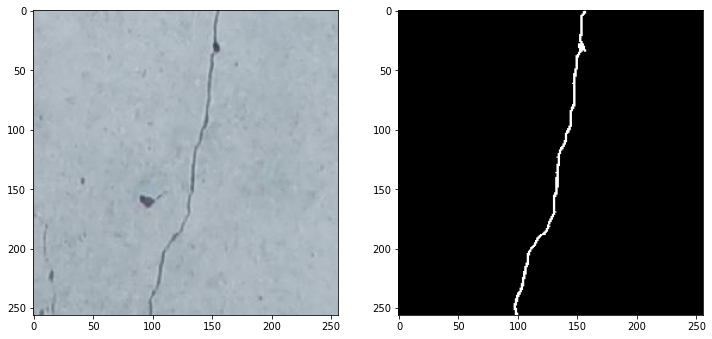

In [ ]:
#Sanity check
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [ ]:
path1 = "/content/7051-169.jpg"
img = cv2.imread(path1,0)

path2 = "/content/7119-168.jpg"
im2 = cv2.imread(path2,0)

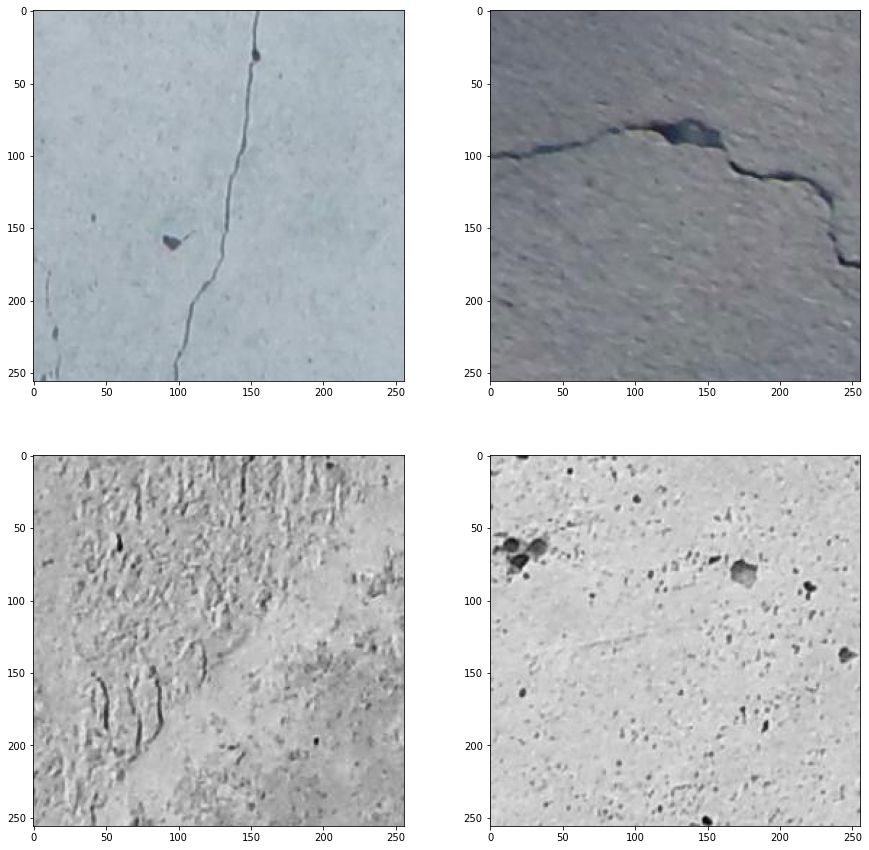

In [ ]:
#Sanity check, view few mages
# image_number = random.randint(0, len(X_train))
image_number2 = random.randint(0, len(X_train))


plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)), cmap='gray')
plt.subplot(222)
plt.imshow(np.reshape(X_train[image_number2], (256, 256, 3)), cmap='gray')
plt.subplot(223)
plt.imshow(img, cmap='gray')
plt.subplot(224)
plt.imshow(im2, cmap='gray')

# Settings

In [ ]:
from keras_unet_collection import losses
epochs = 50
loss_set=[losses.dice]
metrics_set=[tf.keras.metrics.BinaryIoU(target_class_ids=[1]) ,losses.dice_coef]

# Trans U-Net

## Fit model

In [ ]:
from keras_unet_collection.models import transunet_2d

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
num_labels = 1  #Binary
batch_size = 8

In [ ]:
!mkdir /content/trans_unet_checkpoints

filepath = '/content/trans_unet_checkpoints/trans_unet.epoch{epoch:02d}-dice_coef{val_dice_coef:.2f}.hdf5'
f1_checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor="val_dice_coef",
                             verbose=1, 
                             save_best_only=True,
                             mode="max")


callbacks = [f1_checkpoint]

In [ ]:

trans_unet = transunet_2d((256, 256, 3), 
            filter_num=[64, 128, 256, 512, 1024], 
            n_labels=1, 
            activation='ReLU', 
            mlp_activation='GELU', 
            output_activation='Sigmoid', 
            num_heads=8, 
            num_transformer=8,
            batch_norm=True, 
            backbone=None, 
            weights=None, 
            name='transunet')

In [ ]:
trans_unet.compile( optimizer=Adam(lr = 1e-2), 
                    loss=loss_set, 
                    metrics=metrics_set
                  )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
start = datetime.now() 
trans_unet_history = trans_unet.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ),  
                    shuffle=False,
                    epochs=epochs,
                    callbacks=callbacks)

stop = datetime.now()

Epoch 1/50
80/80 [==============================] - ETA: 0s - loss: 0.4617 - binary_io_u: 0.2139 - dice_coef: 0.5383
Epoch 1: val_dice_coef improved from -inf to 0.00000, saving model to /content/trans_unet_checkpoints/trans_unet.epoch01-dice_coef0.00.hdf5
80/80 [==============================] - 97s 970ms/step - loss: 0.4617 - binary_io_u: 0.2139 - dice_coef: 0.5383 - val_loss: 1.0000 - val_binary_io_u: 0.0000e+00 - val_dice_coef: 1.8578e-11
Epoch 2/50
80/80 [==============================] - ETA: 0s - loss: 0.3288 - binary_io_u: 0.5296 - dice_coef: 0.6712
Epoch 2: val_dice_coef improved from 0.00000 to 0.25090, saving model to /content/trans_unet_checkpoints/trans_unet.epoch02-dice_coef0.25.hdf5
80/80 [==============================] - 75s 944ms/step - loss: 0.3288 - binary_io_u: 0.5296 - dice_coef: 0.6712 - val_loss: 0.7491 - val_binary_io_u: 0.1296 - val_dice_coef: 0.2509
Epoch 3/50
80/80 [==============================] - ETA: 0s - loss: 0.2948 - binary_io_u: 0.5676 - dice_coef: 0

In [ ]:
print(f"Execution time: {stop-start}")

Execution time: 1:40:30.729853


## Save model to google drive

In [ ]:
#save best dice model
!cp -r /content/trans_unet_checkpoints/trans_unet.epoch38-dice_coef0.85.hdf5 /content/gdrive/MyDrive/25may

## Evaluate model

In [ ]:
from keras.models import load_model
from keras_unet_collection.transformer_layers import patch_extract, patch_embedding
from keras_unet_collection.activations import GELU

transunet_path = "/content/trans_unet_checkpoints/trans_unet.epoch46-dice_coef0.78.hdf5"
transunet_model = load_model(transunet_path, compile=False, custom_objects={"patch_extract": patch_extract, "patch_embedding": patch_embedding, "GELU": GELU})

### Ground truth vs prediction

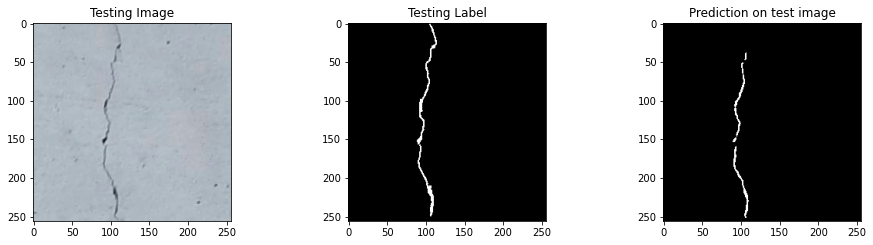

In [ ]:
import random
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (transunet_model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

### IoU for test dataset

In [ ]:
import pandas as pd
from tensorflow.keras.metrics import MeanIoU
n_classes = 2

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (transunet_model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print(f"Mean IoU for test dataset is: {round(mean_IoU[0]*100,2)}%") 

Mean IoU for test dataset is: 80.58%


## probability map

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, \
               labelbottom=False, left=False, right=False, labelleft=False)
    return ax

In [ ]:
y_pred = transunet_model.predict([X_test])

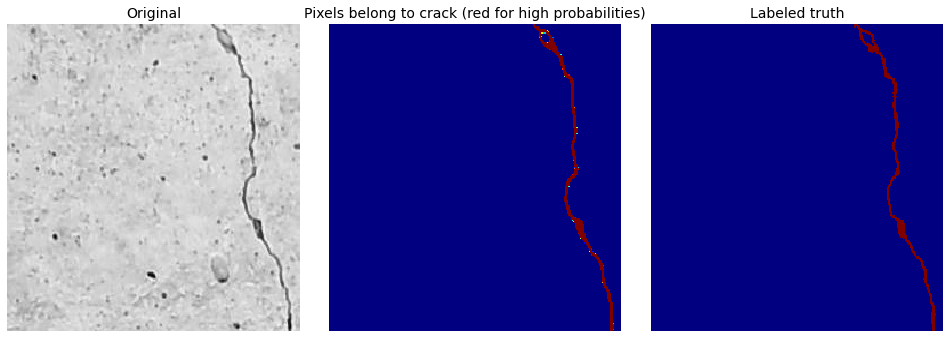

In [ ]:
i_sample = random.randint(0, X_test.shape[0]-1)

fig, AX = plt.subplots(1, 3, figsize=(13, (13-0.2)/3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(X_test[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(y_test[i_sample, ..., 0], cmap=plt.cm.jet)

AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Pixels belong to crack (red for high probabilities)", fontsize=14);
AX[2].set_title("Labeled truth", fontsize=14);